<a href="https://colab.research.google.com/github/tj-mas04/Breast-cancer-detection---SVM/blob/main/SVM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [5]:
# Set up folder paths
train_folder = '/content/drive/MyDrive/dtaet2/train'
test_folder = '/content/drive/MyDrive/dtaet2/test'
valid_folder = '/content/drive/MyDrive/dtaet2/valid'

In [6]:
# Function to load images in grayscale from a specified folder structure
def load_images_from_folder(folder):
    images = []
    labels = []

    for label in ['0', '1']:  # '0' for benign, '1' for malignant
        label_path = os.path.join(folder, label)

        if not os.path.exists(label_path):
            print(f"Warning: Folder {label_path} does not exist.")
            continue

        # Loop through each image file in the folder
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize to 64x64 pixels
                images.append(img)
                labels.append(int(label))
            else:
                print(f"Warning: Could not load image {img_path}")  # Debugging output

    return np.array(images), np.array(labels)


In [7]:
# Load dataset (train, test, valid)
X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)
X_valid, y_valid = load_images_from_folder(valid_folder)

# Normalize the pixel values (optional, helps with model convergence)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

# Flatten grayscale images (64x64) to 1D arrays (4096,)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)


In [8]:
# Create an SVM classifier
clf = svm.SVC(kernel='linear')  # You can also try 'rbf' or 'poly' kernels

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

[[138  70]
 [ 87  41]]
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       208
           1       0.37      0.32      0.34       128

    accuracy                           0.53       336
   macro avg       0.49      0.49      0.49       336
weighted avg       0.52      0.53      0.53       336



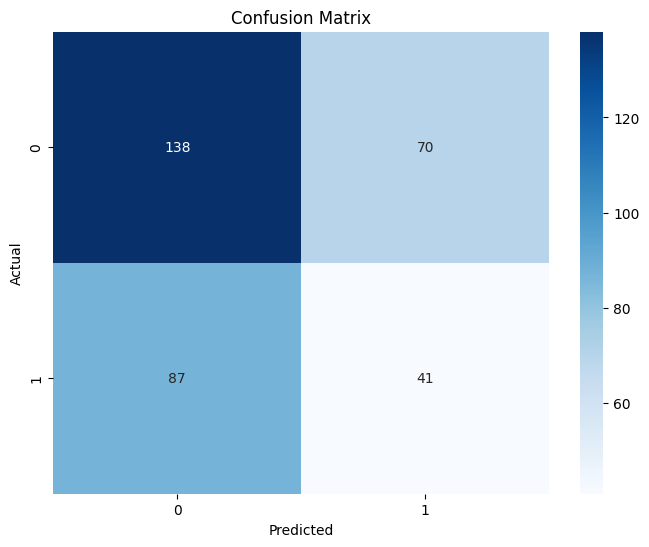

In [9]:
# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [10]:
# Save the model to a file
joblib.dump(clf, '/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

['/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl']

In [11]:
# Load the model
model = joblib.load('/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return "Image not found"

    img = cv2.resize(img, (64, 64))  # Resize to 64x64
    print("Image shape after resizing:", img.shape)  # Debugging output
    img = img.reshape(1, -1)  # Flatten the image
    prediction = model.predict(img)

    # Convert prediction to label
    label = 'Malignant' if prediction[0] == 1 else 'Benign'

    # Display the image with the label
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))  # Read in color for display
    plt.title(f'Prediction: {label}', fontsize=16)
    plt.axis('off')  # Hide axis
    plt.show()

    return label

Image shape after resizing: (64, 64)


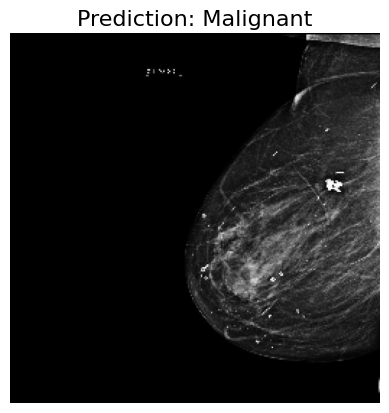

Malignant


In [12]:
print(predict_image('/content/drive/MyDrive/dtaet2/valid/1/10130_1360338805_png.rf.2a2e24224e090892b241f613f8e8d9e6.jpg'))

#Sajal

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import joblib  # to save and load the model

# Function to extract features from an image
def extract_features(image_path):
    print(f"Extracting features from {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error reading image: {image_path}")
        return None

    # Resize image to a fixed size
    image = cv2.resize(image, (128, 128))

    # HOG Feature Extraction
    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

    # SIFT Feature Extraction
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    if descriptors is None:
        sift_features = np.zeros((128,))  # Default if no keypoints detected
    else:
        sift_features = np.mean(descriptors, axis=0)  # Average of SIFT descriptors

    # Color Histogram
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_hist = cv2.normalize(color_hist, color_hist).flatten()

    # Combine all features
    features = np.concatenate((hog_features, sift_features, color_hist))
    print(f"Features extracted for {image_path}")
    return features

# Function to classify a new image using the trained model
def classify_new_image(image_path, model, scaler):
    print(f"Classifying new image: {image_path}")

    # Extract features
    features = extract_features(image_path)
    if features is None:
        return "Error in image processing"

    # Standardize the features using the training data scaler
    features_normalized = scaler.transform([features])  # Reshape and standardize

    # Predict class using trained SVM model
    prediction = model.predict(features_normalized)
    class_names = ['animals', 'man_made', 'nature', 'people']
    predicted_class = class_names[int(prediction[0])]

    print(f"Predicted class: {predicted_class}")
    return predicted_class

# Load dataset from train and test directories
def load_data(data_dir):
    print("Loading data...")
    X = []
    y = []
    categories = ['animals', 'man_made', 'nature', 'people']
    label_map = {category: idx for idx, category in enumerate(categories)}

    # Load training data
    for category in categories:
        category_path_train = os.path.join(data_dir, 'train', category)
        print(f"Loading training data from category: {category}")

        for img_file in os.listdir(category_path_train):
            img_path = os.path.join(category_path_train, img_file)
            features = extract_features(img_path)
            if features is not None:
                X.append(features)
                y.append(label_map[category])

    # Load testing data
    for category in categories:
        category_path_test = os.path.join(data_dir, 'test', category)
        print(f"Loading testing data from category: {category}")

        for img_file in os.listdir(category_path_test):
            img_path = os.path.join(category_path_test, img_file)
            features = extract_features(img_path)
            if features is not None:
                X.append(features)
                y.append(label_map[category])

    print("Data loading complete.")
    return np.array(X), np.array(y)

# Main script
if __name__ == "__main__":
    print("Starting image classification using SVM...")

    # Check if model and scaler exist
    model_file = 'svm_model.pkl'
    scaler_file = 'scaler.pkl'

    if os.path.exists(model_file) and os.path.exists(scaler_file):
        print("Loading the saved model and scaler...")
        model = joblib.load(model_file)
        scaler = joblib.load(scaler_file)
    else:
        print("Model and scaler not found. Training the model...")
        data_dir = 'Labelled Dataset'  # Path to your dataset directory

        # Load the data
        X, y = load_data(data_dir)

        # Print data information
        print(f"Total images processed: {len(y)}")
        print(f"Number of features per image: {X.shape[1]}")

        # Standardize features
        print("Standardizing features...")
        scaler = StandardScaler()

        # Training on 80%, testing on 20%
        X_train = scaler.fit_transform(X[:len(y)//5 * 4])  # 80% for training
        y_train = y[:len(y)//5 * 4]
        X_test = scaler.transform(X[len(y)//5 * 4:])        # 20% for testing
        y_test = y[len(y)//5 * 4:]

        print(f"Training data size: {X_train.shape}")
        print(f"Test data size: {X_test.shape}")

        # Train the SVM model
        print("Training the SVM model...")
        model = svm.SVC(kernel='linear')
        model.fit(X_train, y_train)

        # Save the model and scaler
        joblib.dump(model, model_file)
        joblib.dump(scaler, scaler_file)

        print(f"Model training complete. Model saved as '{model_file}'.")

        # Predictions
        print("Making predictions on test data...")
        y_pred = model.predict(X_test)

        # Evaluation
        print("Classification report:")
        print(classification_report(y_test, y_pred, target_names=['animals', 'man_made', 'nature', 'people']))

    # Example of classifying a new image
    new_image_path = 'building.jpeg'  # Replace with the path to your new image
    predicted_class = classify_new_image(new_image_path, model, scaler)
    print(f"The new image is classified as: {predicted_class}")

#improved model 1


Confusion Matrix:
 [[138  70]
 [ 87  41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.64       208
           1       0.37      0.32      0.34       128

    accuracy                           0.53       336
   macro avg       0.49      0.49      0.49       336
weighted avg       0.52      0.53      0.53       336



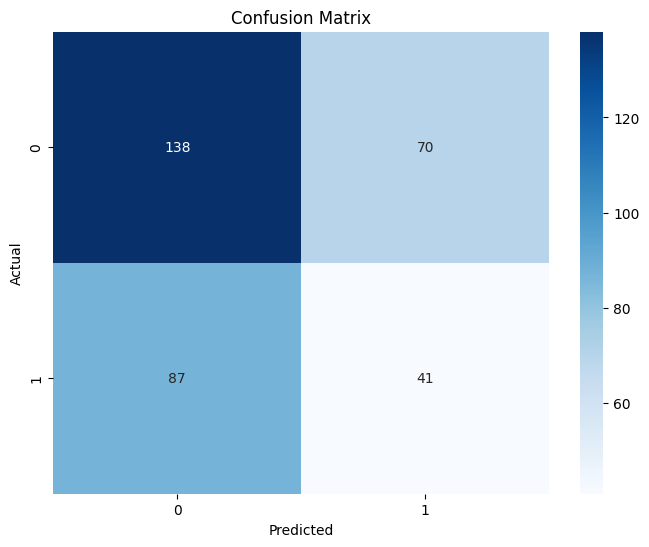

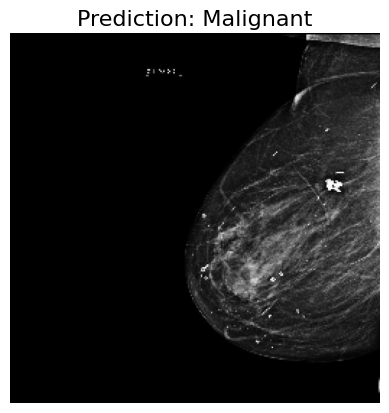

Malignant


In [13]:
import os
import cv2
import numpy as np
from sklearn import svm
from skimage.feature import hog, local_binary_pattern
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Set up folder paths
train_folder = '/content/drive/MyDrive/dtaet2/train'
test_folder = '/content/drive/MyDrive/dtaet2/test'
valid_folder = '/content/drive/MyDrive/dtaet2/valid'

# Parameters for LBP
radius = 1
n_points = 8 * radius

# Function to extract HOG, LBP, and basic pixel features from an image
def extract_features(image):
    # Resize to a standard size (e.g., 64x64)
    image_resized = cv2.resize(image, (64, 64))

    # Feature 1: Raw pixel intensities (flattened)
    pixel_features = image_resized.flatten()

    # Feature 2: HOG (Histogram of Oriented Gradients)
    hog_features = hog(image_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    # Feature 3: LBP (Local Binary Patterns)
    lbp = local_binary_pattern(image_resized, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize the histogram

    # Combine all features into one feature vector
    features = np.hstack([pixel_features, hog_features, lbp_hist])
    return features

# Function to load images and extract features
def load_images_from_folder(folder):
    images = []
    labels = []

    for label in ['0', '1']:  # '0' for benign, '1' for malignant
        label_path = os.path.join(folder, label)

        if not os.path.exists(label_path):
            print(f"Warning: Folder {label_path} does not exist.")
            continue

        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

            if img is not None:
                features = extract_features(img)
                images.append(features)
                labels.append(int(label))
            else:
                print(f"Warning: Could not load image {img_path}")

    return np.array(images), np.array(labels)

# Load dataset (train, test, valid)
X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)
X_valid, y_valid = load_images_from_folder(valid_folder)

# Normalize the pixel values (optional, helps with model convergence)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

# Create an SVM classifier with the 'linear' kernel
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Save the model to a file
joblib.dump(clf, '/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

# Load the model
model = joblib.load('/content/drive/MyDrive/dtaet2/breast_cancer_svm_model.pkl')

# Function to predict a single image
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return "Image not found"

    features = extract_features(img)  # Extract HOG + LBP + pixel features
    features = features.reshape(1, -1)  # Flatten the image for SVM input
    prediction = model.predict(features)

    # Convert prediction to label
    label = 'Malignant' if prediction[0] == 1 else 'Benign'

    # Display the image with the label
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))  # Read in color for display
    plt.title(f'Prediction: {label}', fontsize=16)
    plt.axis('off')  # Hide axis
    plt.show()

    return label

print(predict_image('/content/drive/MyDrive/dtaet2/valid/1/10130_1360338805_png.rf.2a2e24224e090892b241f613f8e8d9e6.jpg'))
